### Imports + utility functions

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import pyproj
from pathlib import Path
from shapely.ops import transform
from shapely.geometry import box, Point
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pystac_client import Client

In [2]:
def utm_crs_from_point(lon, lat):
    
    utm_zone = int(np.floor((lon + 180) / 6) + 1)
    
    if lat >= 0:
        utm_crs = 32600 + utm_zone
    else:
        utm_crs = 32700 + utm_zone 

    return utm_crs

## Rationale

While RCM-ARD uses the following polarizations of RR, RL, and RRRL*, some users may want to stick with the circular-linear configuration.

Conversion back to RH/RV/RHRV* to assist with integration of ARD products into a wider range of processes is simple and lossless.

### Work through STAC catalog to find product URLs

In [3]:
# We will search for late winter / early spring imagery of Hislop Lake, NWT
lon, lat = -116.92284, 63.51382
utm_crs = utm_crs_from_point(lon, lat)

# Filter assets by imaging date
start_date = '2025-02-01'
end_date = '2025-04-15'

In [4]:
cat_url = 'https://www.eodms-sgdot.nrcan-rncan.gc.ca/stac/'
catalog = Client.open(cat_url)
search = catalog.search(
    collections=['rcm-ard'],
    intersects=dict(type="Point", coordinates=[lon, lat]),
    datetime=f'{start_date}/{end_date}',
    limit=100
)

items = search.item_collection()
items = sorted(items, key=lambda item: item.properties['datetime'])
print(f'{len(items)} products found')

2 products found


In [5]:
# Get S3 URLs for cloud-optimized GeoTIFFs used in conversion
ard_product = items[0]
order_key = ard_product.properties['order_key']
rl_url, rr_url, rrrl_url = ard_product.assets['rl'].href, ard_product.assets['rr'].href, ard_product.assets['rrrl'].href

In [6]:
rl_url, rr_url, rrrl_url

('https://rcm-ceos-ard.s3.ca-central-1.amazonaws.com/MLC/2025/04/07/RCM1_OK3433412_PK3553898_1_SC30MCPB_20250407_142810_CH_CV_MLC/RCM1_OK3433412_PK3553898_1_SC30MCPB_20250407_142810_RL.tif',
 'https://rcm-ceos-ard.s3.ca-central-1.amazonaws.com/MLC/2025/04/07/RCM1_OK3433412_PK3553898_1_SC30MCPB_20250407_142810_CH_CV_MLC/RCM1_OK3433412_PK3553898_1_SC30MCPB_20250407_142810_RR.tif',
 'https://rcm-ceos-ard.s3.ca-central-1.amazonaws.com/MLC/2025/04/07/RCM1_OK3433412_PK3553898_1_SC30MCPB_20250407_142810_CH_CV_MLC/RCM1_OK3433412_PK3553898_1_SC30MCPB_20250407_142810_RRRL.tif')

#### Read data from COGs using spatial subset

RRRL* GeoTiff contains 2 bands (real + imaginary) so we define our own read function instead of using stackstac, which only supports single-band rasters

In [7]:
def read_cog_from_bbox(cog_url, bbox=None):
    with rxr.open_rasterio(cog_url) as rds:
        # Reproject bounding box to match raster CRS
        if bbox is None:
            out_cog = rds.copy()
        else:
            bbox_geom = box(*bbox)
            cog_epsg = rds.rio.crs.to_epsg()
        
            project = pyproj.Transformer.from_proj(
                pyproj.Proj('epsg:4326'),  # hard-coded in get_bbox() function 
                pyproj.Proj(f'epsg:{cog_epsg}'),
                always_xy = True) 
            
            # Clip COG to reprojected bounds if provided and return
            bbox_geom_proj = transform(project.transform, bbox_geom)
            out_cog = rds.rio.clip_box(*bbox_geom_proj.bounds)
    
    return out_cog

### RR/RL/RRRL* to RH/RV/RHRV* Conversion

#### Step 1: convert original MLC rasters to Stokes parameters

In [8]:
# Option to process entire product extent or subset by bbox
def ard_to_stokes(rl_url, rr_url, rrrl_url, bbox=None):
    rl, rr, rrrl =  read_cog_from_bbox(rl_url, bbox), read_cog_from_bbox(rr_url, bbox), read_cog_from_bbox(rrrl_url, bbox)
    S0 = rl + rr
    S1 = 2 * rrrl[1, :, :]  # 2nd band is imaginary component
    S2 = 2 * rrrl[0, :, :]  # 1st band is real component
    S3 = rl - rr

    return S0[0], S1, S2, S3[0]  # drop redundant "band" dimension when stil present

In [9]:
# processing entire rcm-ard product here - may take a few minutes to run
S0, S1, S2, S3 = ard_to_stokes(rl_url, rr_url, rrrl_url)

#### Step 2: convert Stokes vectors to RV/RH polarizations

In [10]:
rv = (S0 - S1) / 2
rh = (S0 + S1) / 2

#### Step 3: write results to disk

In [11]:
# original rasters
out_dir = './data'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

out_rv = f'{out_dir}/{Path(rr_url).stem.replace("_RR", "_RV")}.tif'
rv.rio.to_raster(out_rv)
print(f'Exported RV polarization raster to {out_rv}')

out_rh =f'{out_dir}/{Path(rr_url).stem.replace("_RR", "_RH")}.tif'
rh.rio.to_raster(out_rh)
print(f'Exported RH polarization raster to {out_rh}')

Exported RV polarization raster to ./data/RCM1_OK3433412_PK3553898_1_SC30MCPB_20250407_142810_RV.tif
Exported RH polarization raster to ./data/RCM1_OK3433412_PK3553898_1_SC30MCPB_20250407_142810_RH.tif


In [12]:
# convert amplitude to decibels (dB) and fix out-of-range values
rv_db = 10 * np.log10(rv)
rv_db = rv_db.where(~np.isneginf(rv_db), np.nan)
rv_db = rv_db.where(~np.isinf(rv_db), np.nan)

rh_db = 10 * np.log10(rh)
rh_db = rh_db.where(~np.isneginf(rh_db), np.nan)
rh_db = rh_db.where(~np.isinf(rh_db), np.nan)

# save to disk
out_rv_db = f'{out_dir}/{Path(rr_url).stem.replace("_RR", "_RV")}_dB.tif'
rv_db.rio.to_raster(out_rv_db)
print(f'Converted RV polarization raster to dB and saved to {out_rv}')

out_rh_db =f'{out_dir}/{Path(rr_url).stem.replace("_RR", "_RH")}_dB.tif'
rh_db.rio.to_raster(out_rh_db)
print(f'Converted RH polarization raster to dB and saved to {out_rh}')

c:\Users\sleipe\AppData\Local\miniconda3\envs\rcm-stac-env\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
c:\Users\sleipe\AppData\Local\miniconda3\envs\rcm-stac-env\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Converted RV polarization raster to dB and saved to ./data/RCM1_OK3433412_PK3553898_1_SC30MCPB_20250407_142810_RV.tif
Converted RH polarization raster to dB and saved to ./data/RCM1_OK3433412_PK3553898_1_SC30MCPB_20250407_142810_RH.tif


### Exploring Results

In [13]:
# stack multiple polarizations into one array for visualization
with rxr.open_rasterio(rr_url) as rr:
    rr_db = 10 * np.log10(rr[0, :, :])
    rr_db = rr_db.where(~np.isneginf(rr_db), np.nan)
    rr_db = rr_db.where(~np.isinf(rr_db), np.nan)

db_stack = xr.concat([rh_db, rr_db.drop_vars('band'), rv_db], dim='band')
db_stack.coords['band'] = [0, 1, 2]
db_stack.attrs['long_name'] = ['rh', 'rr', 'rv']

c:\Users\sleipe\AppData\Local\miniconda3\envs\rcm-stac-env\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


#### Visualize false-colour RGB of entire scene

In [14]:
def percent_stretch(rds, lower=2, upper=98):
    """Normalize each band in a DataArray using a percentile stretch"""
    stretched_bands = []
    for b in rds:
        pct_low = np.nanpercentile(b.values, lower)
        pct_high = np.nanpercentile(b.values, upper)
        stretched = np.clip(b.values, pct_low, pct_high)
        stretched_bands.append(stretched)

    # Rebuild array with new stretched values
    stretched_array = xr.DataArray(
        data=np.stack(stretched_bands),
        dims=rds.dims,
        coords=rds.coords,
        attrs=rds.attrs,
        name=rds.name
    )
    
    return stretched_array

In [15]:
def normalize_to_rgb(data, vmin=None, vmax=None):
    """Normalize data to 0-1 range for RGB display"""
    if vmin is None:
        vmin = float(data.min().values)
    if vmax is None:
        vmax = float(data.max().values)
    
    normalized = (data - vmin) / (vmax - vmin)
    return normalized.clip(0, 1)

In [16]:
# Apply a stretching function to pixel values to emphasize contrast based on percentiles
db_stack_stretched = percent_stretch(db_stack)

# Use normalized stack for proper display in RGB range
db_stack_norm = xr.concat([
    normalize_to_rgb(db_stack_stretched.sel(band=0)),
    normalize_to_rgb(db_stack_stretched.sel(band=1)), 
    normalize_to_rgb(db_stack_stretched.sel(band=2))
], dim='band')

db_stack_norm.coords['band'] = [0, 1, 2]
db_stack_norm.attrs['long_name'] = ['rh', 'rr', 'rv']

In [17]:
# create a 10km buffer around search point as sub-AOI within scene
pt_df = pd.DataFrame({'id': [0]})
aoi_gdf = gpd.GeoDataFrame(pt_df, geometry = [Point((lon, lat))], crs=4326).to_crs(utm_crs)
aoi_gdf['geometry'] = aoi_gdf.geometry.buffer(10000, cap_style = 3)

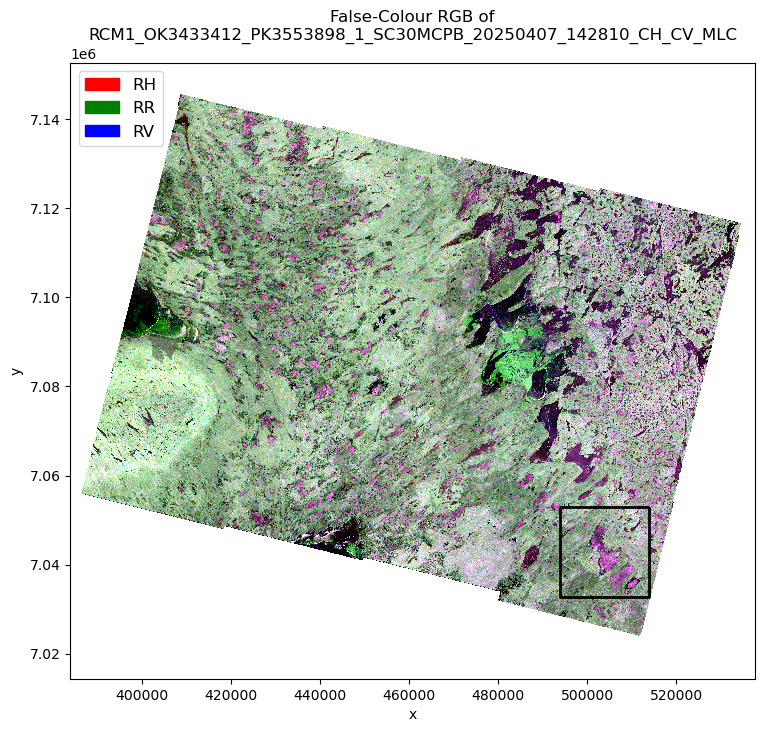

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))

db_stack_norm.plot.imshow(rgb='band', ax=ax)
aoi_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
ax.set(title=f'False-Colour RGB of\n{order_key}')

legend = zip(['red', 'green', 'blue'], [x.upper() for x in db_stack_norm.attrs['long_name']])
patches = [mpatches.Patch(color=color, label=label) for color, label in legend]
ax.legend(handles=patches, loc='upper left', fontsize=12)

#### A closer look at the Behchokǫ̀–Gamètı̀ Winter Road at Hislop Lake

In [19]:
# clip visualization stack to buffered AOI
db_stack_norm_clip = db_stack_norm.rio.clip(aoi_gdf.geometry)

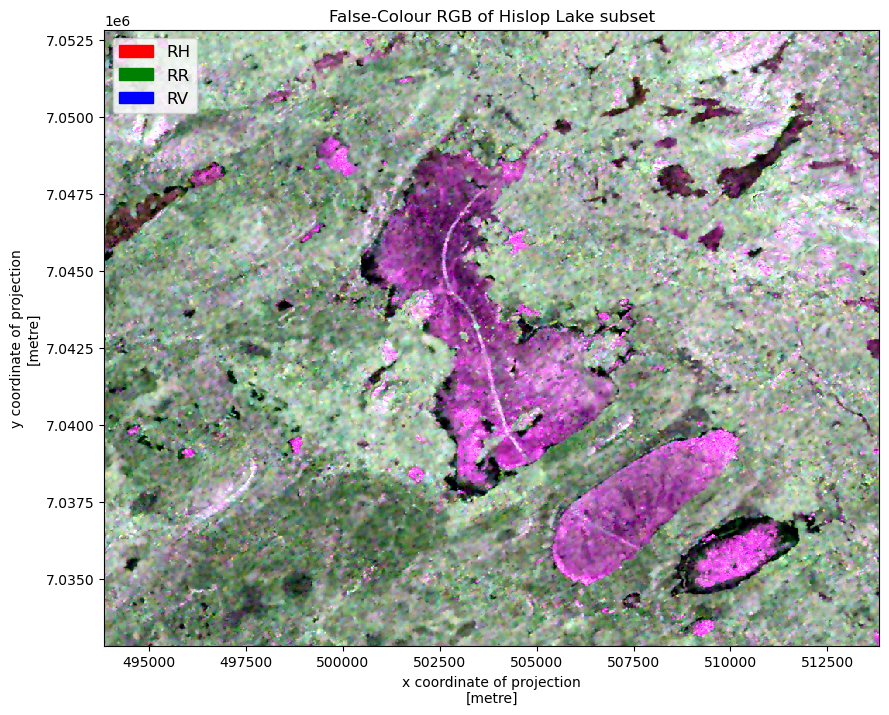

In [20]:
# plot results
fig, ax = plt.subplots(figsize=(10, 8))

db_stack_norm_clip.plot.imshow(rgb='band', ax=ax)
ax.set(title=f'False-Colour RGB of Hislop Lake subset')

legend = zip(['red', 'green', 'blue'], [x.upper() for x in db_stack_norm_clip.attrs['long_name']])
patches = [mpatches.Patch(color=color, label=label) for color, label in legend]
ax.legend(handles=patches, loc='upper left', fontsize=12)